## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}

for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

W0717 23:59:03.184541  4984 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0717 23:59:03.185541  4984 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0717 23:59:03.203542  4984 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0717 23:59:03.204542  4984 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0717 23:59:03.206542  4984 deprecation_wrapper.py:119] From D:\Anaconda3\li

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


W0717 23:59:03.421554  4984 deprecation.py:323] From D:\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 15s 306us/step - loss: 15.0573 - acc: 0.2782 - val_loss: 13.9411 - val_acc: 0.3449
Epoch 2/50
50000/50000 [==============================] - 18s 354us/step - loss: 13.0079 - acc: 0.3605 - val_loss: 12.1155 - val_acc: 0.3767
Epoch 3/50
50000/50000 [==============================] - 20s 393us/step - loss: 11.3362 - acc: 0.3844 - val_loss: 10.5845 - val_acc: 0.3949
Epoch 4/50
50000/50000 [==============================] - 20s 392us/step - loss: 9.9250 - acc: 0.3995 - val_loss: 9.2942 - val_acc: 0.3937
Epoch 5/50
50000/50000 [==============================] - 20s 392us/step - loss: 8.7272 - acc: 0.4083 - val_loss: 8.1833 - val_acc: 0.4147: 8.768
Epoch 6/50
50000/50000 [==============================] - 20s 392us/step - loss: 7.7057 - acc: 0.4156 - val_loss: 7.2409 - val_acc: 0.4197
Epoch 7/50
50000/50000 [==============================] - 20s 392us/step - loss: 6.8338 - acc: 0.4224 -

50000/50000 [==============================] - 21s 416us/step - loss: 2.1489 - acc: 0.2807 - val_loss: 1.9881 - val_acc: 0.3552
Epoch 2/50
50000/50000 [==============================] - 20s 395us/step - loss: 1.9361 - acc: 0.3722 - val_loss: 1.9000 - val_acc: 0.3890
Epoch 3/50
50000/50000 [==============================] - 20s 396us/step - loss: 1.8562 - acc: 0.3998 - val_loss: 1.8277 - val_acc: 0.4071
Epoch 4/50
50000/50000 [==============================] - 20s 396us/step - loss: 1.7977 - acc: 0.4203 - val_loss: 1.7877 - val_acc: 0.4211
Epoch 5/50
50000/50000 [==============================] - 20s 396us/step - loss: 1.7525 - acc: 0.4349 - val_loss: 1.7417 - val_acc: 0.4332
Epoch 6/50
50000/50000 [==============================] - 20s 402us/step - loss: 1.7134 - acc: 0.4495 - val_loss: 1.7080 - val_acc: 0.4476
Epoch 7/50
50000/50000 [==============================] - 21s 416us/step - loss: 1.6792 - acc: 0.4611 - val_loss: 1.6838 - val_acc: 0.4587
Epoch 8/50
50000/50000 [==============

Epoch 2/50
50000/50000 [==============================] - 20s 393us/step - loss: 1.7939 - acc: 0.3699 - val_loss: 1.7390 - val_acc: 0.3885
Epoch 3/50
50000/50000 [==============================] - 20s 396us/step - loss: 1.7120 - acc: 0.4002 - val_loss: 1.6775 - val_acc: 0.4167
Epoch 4/50
50000/50000 [==============================] - 20s 395us/step - loss: 1.6541 - acc: 0.4215 - val_loss: 1.6242 - val_acc: 0.4365
Epoch 5/50
50000/50000 [==============================] - 20s 395us/step - loss: 1.6075 - acc: 0.4375 - val_loss: 1.5871 - val_acc: 0.4438
Epoch 6/50
50000/50000 [==============================] - 20s 396us/step - loss: 1.5684 - acc: 0.4497 - val_loss: 1.5862 - val_acc: 0.4386
Epoch 7/50
50000/50000 [==============================] - 20s 405us/step - loss: 1.5352 - acc: 0.4619 - val_loss: 1.5381 - val_acc: 0.4567
Epoch 8/50
50000/50000 [==============================] - 20s 395us/step - loss: 1.5041 - acc: 0.4726 - val_loss: 1.5071 - val_acc: 0.4659
Epoch 9/50
50000/50000 [===

Epoch 3/50
50000/50000 [==============================] - 20s 394us/step - loss: 1.7104 - acc: 0.3998 - val_loss: 1.6873 - val_acc: 0.4133
Epoch 4/50
50000/50000 [==============================] - 20s 395us/step - loss: 1.6548 - acc: 0.4200 - val_loss: 1.6400 - val_acc: 0.4273
Epoch 5/50
50000/50000 [==============================] - 20s 396us/step - loss: 1.6093 - acc: 0.4357 - val_loss: 1.5976 - val_acc: 0.4384
Epoch 6/50
50000/50000 [==============================] - 20s 398us/step - loss: 1.5727 - acc: 0.4485 - val_loss: 1.5716 - val_acc: 0.4468
Epoch 7/50
50000/50000 [==============================] - 20s 397us/step - loss: 1.5397 - acc: 0.4580 - val_loss: 1.5497 - val_acc: 0.4520
Epoch 8/50
50000/50000 [==============================] - 20s 397us/step - loss: 1.5110 - acc: 0.4703 - val_loss: 1.5207 - val_acc: 0.4640
Epoch 9/50
50000/50000 [==============================] - 20s 398us/step - loss: 1.4829 - acc: 0.4793 - val_loss: 1.4969 - val_acc: 0.4699
Epoch 10/50
50000/50000 [==

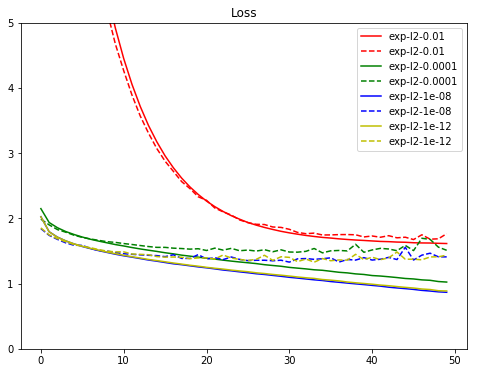

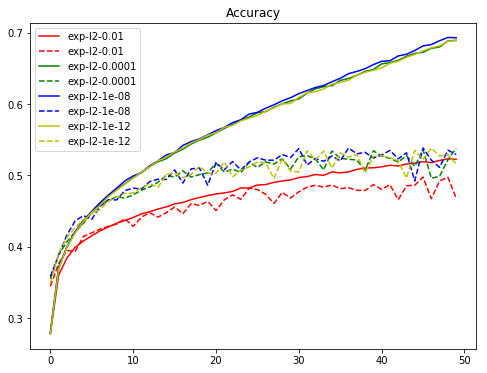

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()